<a href="https://colab.research.google.com/github/LauraGuio/MachineLearning/blob/master/C2_P2_an%C3%A1lisis_sentimientos_Lafaurie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análisis de sentimientos con Twitter (DiaSinCarne)

**Cargar Librerías**

In [50]:
import os
import tweepy as tw 
import pandas as pd

**Permisos de acceso desde Python a el api rest**

In [51]:
consumer_key = 'W4tiErhtxNvpIWfT5B0wc4mTX'
consumer_secret = 'ArG6Btx0j3zPj4YqGnZcA6QeOgYsixmZulWqz72nAioNzS1X8V'
access_token = '1324841042726838273-8W7fCTYm7TpkrfL2rl6KfbdwW6eFXa'
access_token_secret = 'Z26dV3Ji7wmBSylnxb3YXn1oRjpmgTHOQgsQVqNcBYbtf'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

**Consultando Tweets**

In [52]:
# Definir el termino de la busqueda y la fecha de inicio
search_words = '#DiaSinCarne'
date_since = "2019-01-01"
#no tomar retweets
new_search = search_words+" -filter:retweets"
new_search
#Coleccionar tweets (2000 tweets)
tweets = tw.Cursor(api.search, new_search, "es", date_since).items(2000)
tweets

**Convertir Tweets en Dataframe**

In [53]:
data_frame = [[tweet.user.screen_name, tweet.user.location,tweet.text] for tweet in tweets]

tw_dataframe = pd.DataFrame(data= data_frame , columns=["user","location","text"])
tw_dataframe
#lo guardamos en un .csv
tw_dataframe.to_csv('twitter_DiaSinCarne_data.csv', index=False, encoding='utf-8')

**Mostrar algunos datos de Dataframe**

In [55]:
tw_dataframe.head(2000)

,user,location,text
0,PedroLasprilla,,@jaimeflozada @NoraTamayoR Catano aportante a ...
1,Psicotero,,@lcvelez #DiaSinCarne así siempre comienza lo ...
2,jorge_milian,Barranquilla,Y que #DiaSinCarne por qué en su lugar no deja...
3,George1Col,,@micielin La narrativa consiste en un movimien...
4,ANONYMOUSSS2019,#ElPetrismoSeCuraLeyendo,"Ola de homicidios, atracos, violencia en Bogot..."
...,...,...,...
1995,GABRIELSOL88,"Bogotá, D.C., Colombia",#DiaSinCarne acá hacemos todo mal y al revés !...
1996,DiegoCardenas95,Colombia,#DiaSinCarne \n\nEn Colombia varios hogares lo...
1997,PocoCaballero,,#DiaSinCarne pero con carniceros. https://t.co...
1998,UnaCervezaPues,In Spain,@jflafaurie ya dijo que eso del #DiaSinCarne c...


##1. Preprocesamiento de DataFrame

**Cargar librerías**

In [56]:
import re                                #operaciones regulares para la búsqueda y manipulación de cadenas
from nltk import TweetTokenizer          #libreria para tokenizar
from nltk.stem import SnowballStemmer    #algoritmo para clasificación de palabras
#variables para mejorar la escritura (opcional)
NORMALIZE = 'normalize'
REMOVE = 'remove'
MENTION = 'twmention'
HASHTAG = 'twhashtag'
URL = 'twurl'
LAUGH = 'twlaugh'

#definir que el algoritmo de clasificación use el idioma español
_stemmer = SnowballStemmer('spanish')

#definir una variable para la funcion de tokenizar (opcional)
_tokenizer = TweetTokenizer().tokenize

#variable para definir si quiero normalizar: normalize o eliminar: remove los hashtags, menciones y urls en los tweets
_twitter_features="normalize"
#variable para definir si se desea tener convertir o no a la raiz de la palabra.
_stemming=False

**Quitar palabras coloquiales/ tíldes**

In [57]:
#lista de conversión para quitar las tildes a las vocales.
DIACRITICAL_VOWELS = [('á','a'), ('é','e'), ('í','i'), ('ó','o'), ('ú','u'), ('ü','u')]

#lista para corregir algunas palabras coloquiales
SLANG = [('d','de'), ('[qk]','que'), ('xo','pero'), ('xa', 'para'), ('[xp]q','porque'),('es[qk]', 'es que'),
         ('fvr','favor'),('(xfa|xf|pf|plis|pls|porfa)', 'por favor'), ('dnd','donde'), ('tb', 'también'),
         ('(tq|tk)', 'te quiero'), ('(tqm|tkm)', 'te quiero mucho'), ('x','por'), ('\+','mas'),('ily','te quiero mucho')]

**Normalizar risas**

In [58]:
def normalize_laughs(message):
  message = re.sub(r'\b(?=\w*[j])[aeioujs]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(?=\w*[k])[aeiouks]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(juas+|lol)\b', LAUGH, message, flags=re.IGNORECASE)
  return message

**Eliminar menciones, URL, #**

In [59]:
def process_twitter_features(message, twitter_features):

  message = re.sub(r'[\.\,]http','. http', message, flags=re.IGNORECASE)
  message = re.sub(r'[\.\,]#', '. #', message)
  message = re.sub(r'[\.\,]@', '. @', message)

  if twitter_features == REMOVE:
    # eliminar menciones, hashtags y URL
    message = re.sub(r'((?<=\s)|(?<=\A))(@|#)\S+', '', message)
    message = re.sub(r'\b(https?:\S+)\b', '', message, flags=re.IGNORECASE)
  elif twitter_features == NORMALIZE:
    # cuando sea necesario se normalizaran las menciones, hashtags y URL
    message = re.sub(r'((?<=\s)|(?<=\A))@\S+', MENTION, message)
    message = re.sub(r'((?<=\s)|(?<=\A))#\S+', HASHTAG, message)
    message = re.sub(r'\b(https?:\S+)\b', URL, message, flags=re.IGNORECASE)

  return message

**Quitar emojis, caracteres especiales, etc**

In [60]:
def preprocessor_emoji(text):
  text = re.sub('<[^>]*>','', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
  text = (re.sub('[\W]+', ' ', text.lower()) +' '.join(emoticons).replace('-', ''))
  return text

**Preprocesamos**

In [61]:
def preprocess(message):
  # convertir a minusculas
  message = message.lower()
        
  # eliminar números, retorno de linea y retweet
  message = re.sub(r'(\d+|\n|\brt\b)', '', message)
        
  # elimar vocales con signos diacríticos
  for s,t in DIACRITICAL_VOWELS:
    message = re.sub(r'{0}'.format(s), t, message)
        
  # eliminar caracteres repetidos 
  message = re.sub(r'(.)\1{2,}', r'\1\1', message)
       
  # normalizar las risas
  message = normalize_laughs(message)
        
  # traducir la jerga y terminos coloquiales sobre todo en el español
  for s,t in SLANG:
    message = re.sub(r'\b{0}\b'.format(s), t, message)

  #normalizar/eliminar hashtags, menciones y URL
  message = process_twitter_features(message, _twitter_features)

  #eliminar emojis
  message = preprocessor_emoji(message)

  #Convertir las palabras a su raiz
  if _stemming:
    message = ' '.join(_stemmer.stem(w) for w in _tokenizer(message))

  return message

##3. Aplicamos preprocesamiento

In [62]:
import numpy as np
import pandas as pd
#aplicamos el preprocesamiento a los tweets con steaming =false
tw_dataframe ['text'] = tw_dataframe['text'].apply(preprocess)
#eliminamos la columna user y location
#tw_dataframe = tw_dataframe.drop(columns=['user','location'], axis=1)
#guardamos el dataset en un nuvevo CSV para facilitar su posterior uso
tw_dataframe.to_csv('/content/dataset_Lafaurie_full_clean.csv', index=False, encoding='utf-8')

##2. Preprocesamiento de corpus

**Cargar librerías**

In [63]:
import re                                #operaciones regulares para la búsqueda y manipulación de cadenas
from nltk import TweetTokenizer          #libreria para tokenizar
from nltk.stem import SnowballStemmer    #algoritmo para clasificación de palabras
#variables para mejorar la escritura (opcional)
NORMALIZE = 'normalize'
REMOVE = 'remove'
MENTION = 'twmention'
HASHTAG = 'twhashtag'
URL = 'twurl'
LAUGH = 'twlaugh'

#definir que el algoritmo de clasificación use el idioma español
_stemmer = SnowballStemmer('spanish')

#definir una variable para la funcion de tokenizar (opcional)
_tokenizer = TweetTokenizer().tokenize

#variable para definir si quiero normalizar: normalize o eliminar: remove los hashtags, menciones y urls en los tweets
_twitter_features="normalize"
#variable para definir si se desea tener convertir o no a la raiz de la palabra.
_stemming=False

**Quitar palabras coloquiales y tíldes**

In [64]:
#lista de conversión para quitar las tildes a las vocales.
DIACRITICAL_VOWELS = [('á','a'), ('é','e'), ('í','i'), ('ó','o'), ('ú','u'), ('ü','u')]

#lista para corregir algunas palabras coloquiales / jerga en español (obviamente faltan más)
SLANG = [('d','de'), ('[qk]','que'), ('xo','pero'), ('xa', 'para'), ('[xp]q','porque'),('es[qk]', 'es que'),
         ('fvr','favor'),('(xfa|xf|pf|plis|pls|porfa)', 'por favor'), ('dnd','donde'), ('tb', 'también'),
         ('(tq|tk)', 'te quiero'), ('(tqm|tkm)', 'te quiero mucho'), ('x','por'), ('\+','mas')]

**Normalizar risas**

In [65]:
#metodo para normalizar las risas
def normalize_laughs(message):
  message = re.sub(r'\b(?=\w*[j])[aeiouj]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(?=\w*[k])[aeiouk]{4,}\b', LAUGH, message, flags=re.IGNORECASE)
  message = re.sub(r'\b(juas+|lol)\b', LAUGH, message, flags=re.IGNORECASE)
  return message

**Eliminar menciones, #, URL**

In [66]:
def process_twitter_features(message, twitter_features):

  message = re.sub(r'[\.\,]http','. http', message, flags=re.IGNORECASE)
  message = re.sub(r'[\.\,]#', '. #', message)
  message = re.sub(r'[\.\,]@', '. @', message)

  if twitter_features == REMOVE:
    # eliminar menciones, hashtags y URL
    message = re.sub(r'((?<=\s)|(?<=\A))(@|#)\S+', '', message)
    message = re.sub(r'\b(https?:\S+)\b', '', message, flags=re.IGNORECASE)
  elif twitter_features == NORMALIZE:
    # cuando sea necesario se normalizaran las menciones, hashtags y URL
    message = re.sub(r'((?<=\s)|(?<=\A))@\S+', MENTION, message)
    message = re.sub(r'((?<=\s)|(?<=\A))#\S+', HASHTAG, message)
    message = re.sub(r'\b(https?:\S+)\b', URL, message, flags=re.IGNORECASE)

  return message

**Preprocesamiento**

In [67]:
def preprocess(message):
  # convertir a minusculas
  message = message.lower()
        
  # eliminar números, retorno de linea y el tan odios retweet (de los viejos estilos de twitter)
  message = re.sub(r'(\d+|\n|\brt\b)', '', message)
        
  # elimar vocales con signos diacríticos (posible ambigüedad)
  for s,t in DIACRITICAL_VOWELS:
    message = re.sub(r'{0}'.format(s), t, message)
        
  # eliminar caracteres repetidos 
  message = re.sub(r'(.)\1{2,}', r'\1\1', message)
       
  # normalizar las risas
  message = normalize_laughs(message)
        
  # traducir la jerga y terminos coloquiales sobre todo en el español
  for s,t in SLANG:
    message = re.sub(r'\b{0}\b'.format(s), t, message)

  #normalizar/eliminar hashtags, menciones y URL
  message = process_twitter_features(message, _twitter_features)

  #Convertir las palabras a su raiz ( Bonita, bonito) -> bonit 
  if _stemming:
    message = ' '.join(_stemmer.stem(w) for w in _tokenizer(message))

  return message

**Descargar librería NLTK**

In [68]:
#Descargamos la libreria de stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##3. Aplicar preprocesamiento

In [69]:
import numpy as np
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/luisFernandoCastellanosG/Machine_learning/master/An%C3%A1lisis%20de%20sentimientos%20en%20Twitter/espa%C3%B1ol/datasets/Corpus/dataset_2017_full.csv', encoding='utf-8')
#asignamos nombres a las columnas del csv para facilitar la busqueda de información
df.columns = ['tweetid', 'tweet','sentiment']
#aplicamos el preprocesamiento a los tweets con steaming =false
df['tweet'] = df['tweet'].apply(preprocess)
#eliminamos la columna tweetid que no nos sirve para entrenar y si nos genera mas uso de memoria 
df = df.drop(columns="tweetid")
#Es mejor trabajar con valores enteros que con letras
#por lo tanto reemplazaremos los sentimientos que estan como NONE->-1 | NEU -> 0 | P->1 | N->2
df.loc[df['sentiment'] == 'NONE', 'sentiment'] = '-1'
df.loc[df['sentiment'] == 'NEU', 'sentiment'] = '0'
df.loc[df['sentiment'] == 'P', 'sentiment'] = '1'
df.loc[df['sentiment'] == 'N', 'sentiment'] = '2'
df["sentiment"].unique()
#guardamos el dataset en un nuvevo CSV para facilitar su posterior uso
df.to_csv('/content/dataset_2017_full_clean.csv', index=False, encoding='utf-8')

##4. Entrenar modelo

**Librerías necesarias**

In [70]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [71]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
import re
import numpy as np
from nltk.corpus import stopwords

**Tokenizar**

In [72]:
#p2.1: funcion tokenizar con esteroides --tokeniza y limpia--
print("p2.1: funcion tokenizar con esteroides --tokeniza y limpia--")
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized
#p2.2: funcion para extraer un documento del dataset  
print("p2.2: funcion para extraer un documento del dataset  ")
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv)  # skip header
        for line in csv:
            text, label = line[:-3],  int(line[-2])
            yield text, label
#p2.3: funcion que tomara una secuencia de documentos y devolvera un número particular de documentos
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

p2.1: funcion tokenizar con esteroides --tokeniza y limpia--
p2.2: funcion para extraer un documento del dataset  


**Entrenamiento con modelo de regresión logística**

In [73]:
path='/content/dataset_2017_full_clean.csv'
#p2: definimos una versión liviana de CountVectorizer+TfidfVectorizer llamada HashingVectorizer

vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**21,
                         preprocessor=None, 
                         tokenizer=tokenizer)

#definimos como algoritmo la regressión logistica en el decenso gradiante 

clf = SGDClassifier(loss='log', random_state=1, max_iter=1)
doc_stream = stream_docs(path)
#p3. entrenamos 
stop = stopwords.words('spanish')
#pbar = pyprind.ProgBar(50)
#definimos las clases con las cuales vamos a entrenar
classes = np.array([-1,0, 1,2])
#hacemos 50 repeticiones
for _ in range(50):
  #tomaremos grupos de 500 tweets para entrenar
    X_train, y_train = get_minibatch(doc_stream, size=500)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes=classes)
    #pbar.update()
#probamos la eficiencia del modelo con 500 tweets .
X_test, y_test = get_minibatch(doc_stream, size=500)
X_test = vect.transform(X_test)
print('Presición del modelo: %.3f' % clf.score(X_test, y_test))
#recalibramos el modelo.
clf = clf.partial_fit(X_test, y_test)

Presición del modelo: 0.844


##5. Recorremos el dataset de Tweets ya procesados y lo clasificamos dependiendo el Dataset TAS

In [74]:
pip install pyprind

In [75]:
import pyprind

In [76]:
import numpy as np
import pandas as pd
import pyprind

pbar = pyprind.ProgBar(50000)

df = pd.read_csv('/content/dataset_Lafaurie_full_clean.csv', encoding='utf-8')
#creamos una columna llamada Sentimient donde guardaremos la predicción
df['sentiment'] =''
#creamos una columna llamada Probability donde guardaremos la acertabilidad que dio el clasificador
df['probability']=0
#conversión de sentimientos (numeros a palabras)= NONE->-1 | NEU -> 0 | P->1 | N->2
label = {-1:'Sin sentimiento', 0:'Neutro', 1:'Positivo',2: 'Negativo'}
for rowid in range(len(df.index)):
  text=df['text'][rowid]
  textConvert = vect.transform([text]) 
  df['sentiment'][rowid]=label[clf.predict(textConvert)[0]]
  df['probability'][rowid]=np.max(clf.predict_proba(textConvert))*100
  pbar.update()
df.head(20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
0% [#                             ] 100% | ETA: 00:34:52

,user,location,text,sentiment,probability
0,PedroLasprilla,NaN,twmention twmention catano aportante a campaña...,Positivo,87
1,Psicotero,NaN,twmention twhashtag asi siempre comienza lo qu...,Positivo,94
2,jorge_milian,Barranquilla,y que twhashtag por que en su lugar no dejan d...,Positivo,74
3,George1Col,NaN,twmention la narrativa consiste en un movimien...,Positivo,82
4,ANONYMOUSSS2019,#ElPetrismoSeCuraLeyendo,ola de homicidios atracos violencia en bogota ...,Positivo,74
5,JuanCar24388345,NaN,twmention a los de izquierda les gusta los deg...,Positivo,84
6,duvanzarama,NaN,twhashtag semana sin carne meses sin carne es ...,Positivo,75
7,elsalgadob,"Bogotá, Colombia.",el twhashtag de muchos comenzo con la pandemia,Positivo,81
8,JuanJoDuarte1,Bucaramanga - Colombia,donde saquen el dia sin arroz nos joden a todo...,Positivo,84
9,FabianFontecha,Colombia,twmention algunos no estaban muy convencidos d...,Positivo,86


In [77]:
def f_prediction(row):
  text=row['text']
  textConvert = vect.transform([text]) 
  return label[clf.predict(textConvert)[0]]

def f_probability(row):
  text=row['text']
  textConvert = vect.transform([text]) 
  return np.max(clf.predict_proba(textConvert))*100

df["sentiment"] = df.apply(f_prediction, axis=1) # recorriendo columnas
df["probability"] = df.apply(f_probability, axis=1) # recorriendo columnas

sentiment
Negativo      18
Positivo    1982
dtype: int64


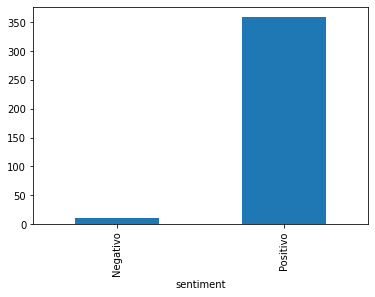

In [78]:
import matplotlib.pyplot as plt
#sentimientos = df["sentiment"].unique()
df.groupby('sentiment')['location'].nunique().plot(kind='bar')
print(df.groupby(['sentiment']).size())
#df.groupby(['sentiment']).size().unstack().plot(kind='bar',stacked=True)
plt.show()